# C-Value/NC-Value

Para la extracción de términos multipalabra se puede usar una aproximación formal que se fija en la estructura de los términos. La estructura de los términos se puede determinar por sus etiquetas POS. Esto proponen los métodos de C-Value y NC-Value que aqui implementamos.

In [1]:
from nltk.corpus import brown, stopwords
from nltk.stem import SnowballStemmer
from collections import defaultdict, Counter
from itertools import chain, combinations
from operator import itemgetter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
#Recupera las oraciones de una categoría
sentences = [sent for sent in brown.tagged_sents(categories=['religion'])]
#untag_sents = brown.sents(categories=['religion'])

#Recupera los tokens para la misma categoría
tokens = brown.words(categories=['religion'])

Las estructuras que asumimos en C-Value son las siguientes:

* Artículo + Sustantivo + Preposición + Sustantivo
* Artículo + Adjetivo + Sustantivo
* Adjetivo + Sustantivo
* Sustantivo + Preposición + Sustantivo

Para definirlas nos basamos en el etiquetado POS del corpus.

In [3]:
#Estructuras de términos
structure = [['AT', 'NN', 'IN', 'NN'], ['AT', 'JJ', 'NN'], ['JJ', 'NN'], ['NN','IN','NN']]

Procedemos, entonces, a encontrar todas aquellas cadenas en el corpus que cumplan con alguna de las estructuras que hemos definido para términos.

In [4]:
#Candidatos a términos
candidates = []
cand_cont = []

for pattern in structure:
    #Longitud del patrón estructural
    k = len(pattern)
    for sent in sentences:
        for i in range(len(sent)-k):
            #Revisa si las oraciones del corpus cumplen algún patrón
            if pattern == [sent[i+j][1] for j in range(k)]:
                #Si se cumple el patrón se agrega la oración como candidato
                candidates.append(' '.join([sent[i+j][0] for j in range(k)]))
                #Guarda el candidato sólo los términos
                cand_cont.append([w[0] for w in sent])

Entonces, contamos la frecuencia de los candidatos a términos.

In [5]:
#Contar las frecuencias de los candidatos
freq_cands = Counter(candidates)
#Guarda en DataFrame
terms = pd.DataFrame(data=freq_cands.values(),index=list(freq_cands.keys()), columns=['Frequency'])
#Visualiza ordenadamente
terms.sort_values(by='Frequency',ascending=False)

,Frequency
human race,10
the human race,8
real estate,8
Christian faith,8
the Christian faith,7
...,...
a two-hour train,1
the keen perception,1
a long evening,1
an early supper,1


El valor de C-Value busca determinar los mejores candidatos basados en la longitud de los candidatos y en su frecuencia. Asimismo, puede haber candidatos anidados, es decir, que estén contenidos dentro de otros candidatos, para eso revisamos si hay anidaciones. El C-Value se calcula como:

$$CValue(w) = \begin{cases} \log_2|w| \cdot f_w & \text{si está anidado} \\
                    \log_2|w| \big( f_w - \frac{1}{|T_w|} \sum_{v\in T_w} f_v  \big)
            \end{cases}$$

In [6]:
#Guarda los C-Values
CValues = {}
for cand in freq_cands.keys():
    #Tokeniza el candidato
    w = cand.split()
    #Revisa si los candidatos están anidados
    c = []
    for nest in freq_cands.keys():
        #Guarda los candidatos anidados
        if cand in nest and cand != nest:
            c.append(nest)
            
    #Si no hay candidatos anidados
    if len(c) == 0:
        CValues[cand] = np.log2(len(w))*freq_cands[cand]
    #En otro caso
    else:
        CValues[cand] = np.log2(len(w))*freq_cands[cand] - sum([freq_cands[nest] for nest in c])/len(c)

Visualizamos los valores obtenidos.

In [7]:
#Agrega C-Value al dataframe
terms['C-Value'] = CValues.values()

terms.sort_values(by='C-Value',ascending=False)

,Frequency,C-Value
the human race,8,12.679700
the middle number,7,11.094738
the Christian faith,7,11.094738
real estate,8,7.000000
the magic square,4,6.339850
...,...,...
great cathedral,1,0.000000
great organ,1,0.000000
vast orchestra,1,0.000000
different problem,1,0.000000


Y también podemos visualizar la nube de palabras con respecto al C-Value

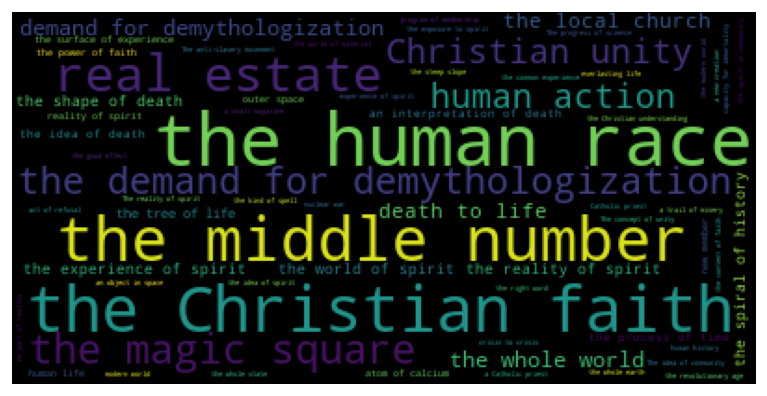

In [8]:
mycloud = WordCloud()

mycloud.generate_from_frequencies(CValues)

plt.figure(figsize=(8,6), dpi=120)
plt.imshow(mycloud)
plt.axis("off")
plt.show()

## NC-Value

El NC-Value busca incorporar información contextual de los términos para poder mejorar los pesos de estos y obtener mejores resultados que con C-Value. Para esto toma en cuenta un peso de términos que se determina como:

$$weight(t) = \frac{|\{w : t \text{ coocurre con } w\}|}{\sum_i f_i}$$

In [9]:
#Obtiene frecuencia de términos
token_freq = Counter(tokens)
#Guarda los pesos
weights = {}
for term in token_freq.keys():
    #Frecuencia de coocurrencia
    t_term = 0
    for sent in cand_cont:
        #Suma cada vez que el término
        #aparece en el candidato.
        if term in sent:
            t_term += 1
    #Peso final
    weights[term] = t_term/len(tokens)

El NC-Value de un candidato a término (multipalabra), $w$, está dado por:

$$NCValue(w) = \lambda CValue(w) + (1-\lambda) \sum_{t\in C_w} f_{t|w} weight(t)$$

In [10]:
#Guarda NC-Values
NCValues = {}
for term,cvalue in CValues.items():
    #Guarda el contexto
    context = []
    for sent in cand_cont:
        #Revisa si el término está en el contexto
        if term in ' '.join(sent):
            context.append([w for w in sent if w not in term.split()])
            
    #Suma los valores de los contextos.
    context_value = sum([f_ba*weights[b] for b, f_ba in Counter(chain(*context)).items()])
    #Guarda el NC-Value
    NCValues[term] = 0.8*cvalue + 0.2*context_value

Podemos comparar los valores de NV-Value con C-Value

In [11]:
#Agrega NC-Value al dataframe
terms['NC-Value'] = NCValues.values()

terms.sort_values(by='NC-Value',ascending=False)

,Frequency,C-Value,NC-Value
the human race,8,12.679700,12.941303
the middle number,7,11.094738,10.856064
the Christian faith,7,11.094738,10.508436
human action,5,5.000000,7.346318
the magic square,4,6.339850,6.720440
...,...,...,...
simple ivory,1,0.000000,0.039463
good word,1,0.000000,0.034153
hard time,1,0.000000,0.032346
human soul,1,0.000000,0.029219


Visualizamos la nube de palabras en base a los valores de NC-Value.

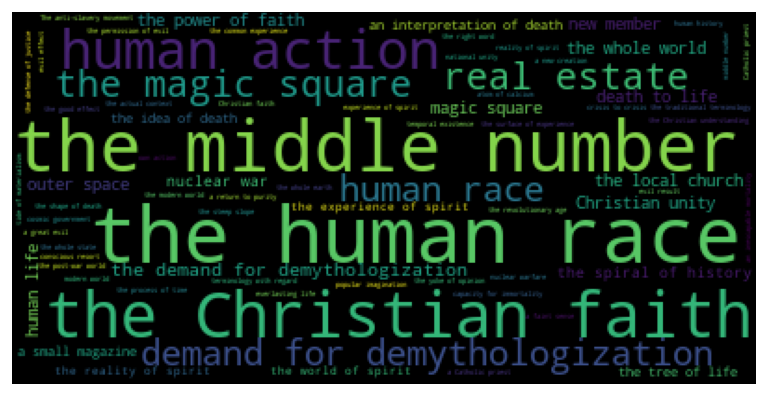

In [12]:
mycloud = WordCloud()

mycloud.generate_from_frequencies(NCValues)

plt.figure(figsize=(8,6), dpi=120)
plt.imshow(mycloud)
plt.axis("off")
plt.show()